<a id = 'top'></a>
### Australian rainfall prediction
- [Aim](#aim)
- [Data](#data)
    - [Loading the data](#load)
    - [Data wrangling](#clean)
       - [Handling null values](#nulls)
       - [Handling duplicated rows](#duplicates)
       - [Converting Categorical variables into Numeric variables](#convert)
- [Statistical Data Analysis](#eda)
- [Data Normalization and train test splitting](#norm)
-  **Model building**
  - [Logistic Regressoion ](#logrx)
  - [Knn classifier](#knn)
  - [Random Forest Classifier](#rforest)
  - [Ann classifier](#ann)

- [Comparing the performance of models and report](#conclusion)
------------------------------------------------------------------------------------[BACK TO TOP](#top)

In [1]:
import numpy as np,pandas as pd
import tensorflow as tf
import sklearn
import math,random,scipy,os
import matplotlib.pyplot as plt,seaborn as sns,plotly.express as px
plt.style.use('fivethirtyeight')

<a id = 'aim'></a>
### Aim
- Build a Predictive Classification model which can predict wether a location in Australia receives
  rainfall tomorrow (0 for No and 1 for Yes) , based on the today's climate conditions  
------------------------------------------------------------------------------------[BACK TO TOP](#top)

<a id = 'data'></a>
### Data
- We will be using statistical weather data of various locations across Australia
- the dataset (csv format) is available on kaggle at [LINK]()

**Description of fields in the dataset**
- various fields present in the data and their description
    Location - Name of the city from Australia.   
    MinTemp - The Minimum temperature during a particular day. (degree Celsius)  
    MaxTemp - The maximum temperature during a particular day. (degree Celsius)  
    Rainfall - Rainfall during a particular day. (millimeters)   
    Evaporation - Evaporation during a particular day. (millimeters)   
    Sunshine - Bright sunshine during a particular day. (hours)    
    WindGusDir - The direction of the strongest gust during a particular day. (16 compass points)   
    WindGuSpeed - Speed of strongest gust during a particular day. (kilometers per hour)   
    WindDir9am - The direction of the wind for 10 min prior to 9 am. (compass points)   
    WindDir3pm - The direction of the wind for 10 min prior to 3 pm. (compass points)   
    WindSpeed9am - Speed of the wind for 10 min prior to 9 am. (kilometers per hour)   
    WindSpeed3pm - Speed of the wind for 10 min prior to 3 pm. (kilometers per hour)   
    Humidity9am - The humidity of the wind at 9 am. (percent)   
    Humidity3pm - The humidity of the wind at 3 pm. (percent)   
    Pressure9am - Atmospheric pressure at 9 am. (hectopascals)   
    Pressure3pm - Atmospheric pressure at 3 pm. (hectopascals)   
    Cloud9am - Cloud-obscured portions of the sky at 9 am. (eighths)   
    Cloud3pm - Cloud-obscured portions of the sky at 3 pm. (eighths)   
    Temp9am - The temperature at 9 am. (degree Celsius)    
    Temp3pm - The temperature at 3 pm. (degree Celsius)   
    RainToday - If today is rainy then ‘Yes’. If today is not rainy then ‘No’.   
    RainTomorrow - If tomorrow is rainy then 1 (Yes). If tomorrow is not rainy then 0 (No).   
------------------------------------------------------------------------------------[BACK TO TOP](#top)

<a id = 'load'></a>
### loading the data

In [3]:
df = pd.read_csv('datasets/australian_weather/Weather_Training_Data.csv')
df.head(3)

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0


<a id = 'clean'></a>
### Data Wrangling
- we will load the data and start preparing it

**Preparation involves**
1. drop unnecessary fields
2. finding the nulls present in every field
   1. the null values will be replaced by mean of that numeric field or
   2. if it is a catfield they will be replaced by the mode of that field
   3. if target fields contain nulls we will drop those records
3. check wether there are any duplicated rows if they exist we will drop them
4. convert categorical variables into numeric variables and store their mapping
5. normalizing every field using zscore ((value-mean)/std)
------------------------------------------------------------------------------------[BACK TO TOP](#top)

In [4]:
# dropping unnecessary fields
df = df.drop(columns=['row ID'])

<a id = 'nulls'></a>
#### Dealing with null values

In [7]:
# take look at the datatypes of the fields
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow       int64
dtype: object

In [5]:
# finding the no of nulls in each field of the dataframe
df.isnull().sum()

Location             0
MinTemp            443
MaxTemp            230
Rainfall           979
Evaporation      42531
Sunshine         47317
WindGustDir       6521
WindGustSpeed     6480
WindDir9am        7006
WindDir3pm        2648
WindSpeed9am       935
WindSpeed3pm      1835
Humidity9am       1233
Humidity3pm       2506
Pressure9am       9748
Pressure3pm       9736
Cloud9am         37572
Cloud3pm         40002
Temp9am            614
Temp3pm           1904
RainToday          979
RainTomorrow         0
dtype: int64

In [6]:
# loop through every numerical field and set null values in that field with mean of that field
for field,dt in zip(list(df.columns),list(df.dtypes)):
    if dt == np.dtype('float64'):
        df[field]= df[field].replace(np.nan,df[field].mean())
# replacing the null values of a categorical fields with their mode
df['WindGustDir']=df['WindGustDir'].replace(np.nan,df['WindGustDir'].mode()[0])
df['WindDir9am'] = df['WindDir9am'].replace(np.nan,df['WindDir9am'].mode()[0])
df['WindDir3pm'] = df['WindDir3pm'].replace(np.nan,df['WindDir3pm'].mode()[0])
df = df.dropna(subset=['RainToday']) # dropping those records with today rain as none
df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

<a id = 'duplicates'></a>
#### Dropping duplicated rows

In [7]:
# checking for duplicated records 
print(df.duplicated().sum() )  # check for no of duplicated rows
df = df.drop_duplicates()     # drop the duplicated rows
df.duplicated().sum()

28


0

<a id = 'convert'></a>
#### Converting categorical variables into numeric variable

In [8]:
# storing the mapping between cat variables and their numerical relationship
meta = {} # dict to store the catvariables code
meta['Location']=sorted(list(df['Location'].unique()))
meta['WindGustDir'] = sorted(list(df['WindGustDir'].unique()))
meta['WindDir9am'] = sorted(list(df['WindDir9am'].unique()))
meta['WindDir3pm'] = sorted(list(df['WindDir3pm'].unique()))
meta['RainToday'] = sorted(list(df['RainToday'].unique()))
print(meta)

{'Location': ['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'], 'WindGustDir': ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'], 'WindDir9am': ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'], 'WindDir3pm': ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'], 'RainToday': ['N

In [9]:
# now we will be converting the variables in cat fields into numeric
# the unique values in the field will be found , sorted and then indexed from 0
# based on their position
df['Location']=df['Location'].astype('category').cat.codes
df['WindGustDir']=df['WindGustDir'].astype('category').cat.codes
df['WindDir9am']=df['WindDir9am'].astype('category').cat.codes
df['WindDir3pm']=df['WindDir3pm'].astype('category').cat.codes
df['RainToday']=df['RainToday'].astype('category').cat.codes

<a id = 'eda'></a>
### Statistical data analysis
- Understanding the basic relatioship between various variables in the data
- and finding which variables has most effect on our target variable(RainTomorrow)

**FINDINGS**  
1. Location,Mintemp,Windgustdirection,wind direction at 2pm and 9am , Temp at 9 am has
   least effect on Tomorrows rainfall
   while
2. Humidity,Pressure,Maxtemp,Temp at 3pm,Today's Rainfall,sunshine,clouds has most effect on 
   Tomorrow's Rainfall

Text(0.5, 1.0, 'Correlation between Various Fields')

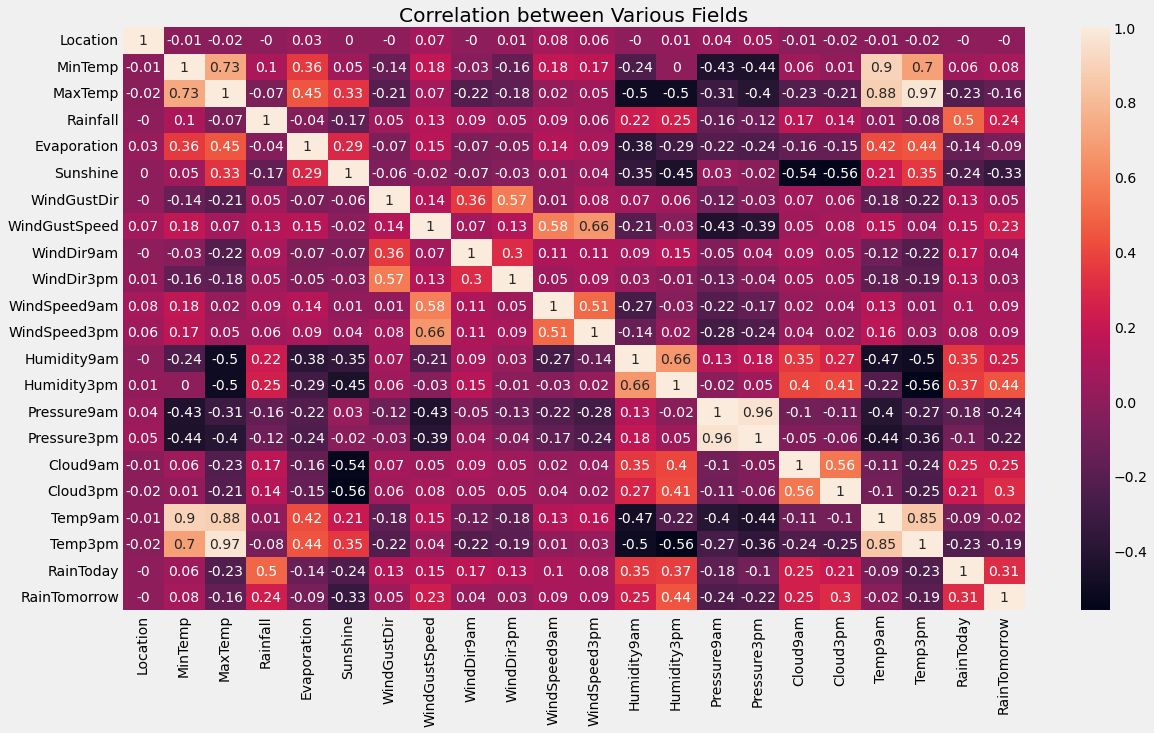

In [16]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr().round(2),annot=True)
plt.title('Correlation between Various Fields')

In [10]:
# considering only those fields that have effect on the target variable
colnames = list(df.columns)
for r in ['Location','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm','Temp9am']: 
    colnames.remove(r)
xdata = df[colnames]
ydata = df['RainTomorrow']
print(xdata.shape,ydata.shape)

(98509, 16) (98509,)


<a id = 'norm'></a>
#### Normalizing the data
- the fields are zscore normalized to improve the rate of convergence

In [11]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler(with_mean=True,with_std=True)
norm.fit(xdata)
xdata = norm.transform(xdata)

<a id = 'split'></a>
#### Train test splitting
- we will split our data in 90:5:5 ratio
- ie use 90 % of examples to train, 5 % to cross validate and remaiing 5% to test our model
- we can achieve this by first splitting data into 95:5 , 95% trainset and 5 % test set and then
  crossvalidating the training test by 19 folds 

In [12]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=.05)
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(93583, 16) (93583,)
(4926, 16) (4926,)


<a id = 'logrx'></a>
### Logistic Regression model

the best set of hyper prameters are 
 {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
the best validation score =  0.8448438937417243
Error metrics on test set 
               precision    recall  f1-score   support

           0       0.87      0.95      0.90      3826
           1       0.72      0.49      0.58      1100

    accuracy                           0.84      4926
   macro avg       0.79      0.72      0.74      4926
weighted avg       0.83      0.84      0.83      4926



Text(13.060000000000002, 0.5, 'actual')

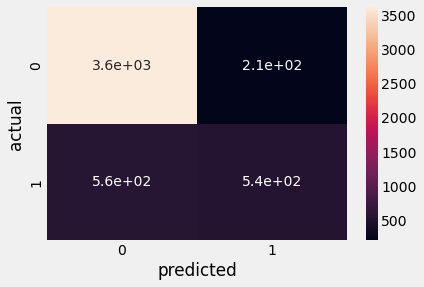

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

log = LogisticRegression()
para = {'C':np.logspace(-3,1,5),  # inv of regularisation constant
       'penalty':['l2'],          # type of regularisation
       'solver':['lbfgs']}

logcv = GridSearchCV(log,para,cv=19) 
logcv.fit(xtrain,ytrain)
print('the best set of hyper prameters are \n',logcv.best_params_)
print('the best validation score = ',logcv.best_score_)

yhat = logcv.predict(xtest)

print('Error metrics on test set \n',classification_report(ytest,yhat))
sns.heatmap(pd.DataFrame(confusion_matrix(ytest,yhat),columns=[0,1],index=[0,1]),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')

<a id = 'knn'></a>
### Knn Classifier model

_______________________________________________________
the best set of hyper prameters are 
 {'n_neighbors': 40}
the best cross validation error =  0.8447797914070808
_______________________________________________________
Error metrics on test set 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      3826
           1       0.75      0.45      0.56      1100

    accuracy                           0.84      4926
   macro avg       0.81      0.70      0.73      4926
weighted avg       0.83      0.84      0.83      4926



Text(13.060000000000002, 0.5, 'actual')

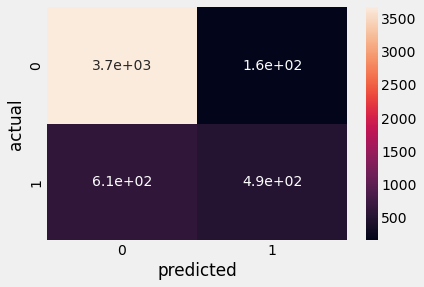

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

para = {'n_neighbors':[20,40,60]}
knncv = GridSearchCV(knn,para,cv=19) # train on 18 folds and cross validate on 19th fold
knncv.fit(xtrain,ytrain)           # train and cross validate
print('_______________________________________________________')
print('the best set of hyper prameters are \n',knncv.best_params_)
print('the best cross validation error = ', knncv.best_score_)
print('_______________________________________________________')
yhat = knncv.predict(xtest)

print('Error metrics on test set \n',classification_report(ytest,yhat))
sns.heatmap(pd.DataFrame(confusion_matrix(ytest,yhat),columns=[0,1],index=[0,1]),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')     

<a id = 'rforest'></a>
### Random Forest classifier

_______________________________________________________
the best set of hyper prameters are 
 {'max_depth': 12, 'n_estimators': 9}
the best cross validation error =  0.8483273787887612
_______________________________________________________
Error metrics on test set 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      3826
           1       0.75      0.49      0.59      1100

    accuracy                           0.85      4926
   macro avg       0.81      0.72      0.75      4926
weighted avg       0.84      0.85      0.84      4926



Text(13.060000000000002, 0.5, 'actual')

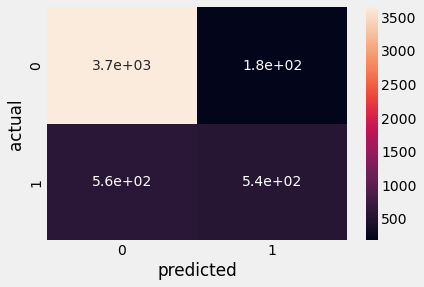

In [16]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier()
para = {
        'n_estimators':list(range(5,10)),
        'max_depth' :[2*n for n in range(1,10)],}

rforestcv = GridSearchCV(rforest,para,cv=19)
rforestcv.fit(xtrain,ytrain)
print('_______________________________________________________')
print('the best set of hyper prameters are \n',rforestcv.best_params_)
print('the best cross validation error = ', rforestcv.best_score_)
print('_______________________________________________________')
yhat = rforestcv.predict(xtest)

print('Error metrics on test set \n',classification_report(ytest,yhat))
sns.heatmap(pd.DataFrame(confusion_matrix(ytest,yhat),columns=[0,1],index=[0,1]),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual') 

<a id = 'ann'></a>
### Artifical neural network classifier
- we will be using a 3 layered neural network to classify each input example 

Epoch 1/5
2771/2771 [==============================] - 9s 3ms/step - loss: 0.3809 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.3698 - val_sparse_categorical_accuracy: 0.8370
Epoch 2/5
2771/2771 [==============================] - 7s 3ms/step - loss: 0.3587 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.3629 - val_sparse_categorical_accuracy: 0.8453
Epoch 3/5
2771/2771 [==============================] - 8s 3ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.8467 - val_loss: 0.3610 - val_sparse_categorical_accuracy: 0.8457
Epoch 4/5
2771/2771 [==============================] - 7s 3ms/step - loss: 0.3537 - sparse_categorical_accuracy: 0.8472 - val_loss: 0.3613 - val_sparse_categorical_accuracy: 0.8419
Epoch 5/5
154/154 [==============================] - 1s 2ms/step
Error metrics on test set 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      3837
           1       0.72      0.47      0.57      1089

    accuracy       

Text(13.060000000000002, 0.5, 'actual')

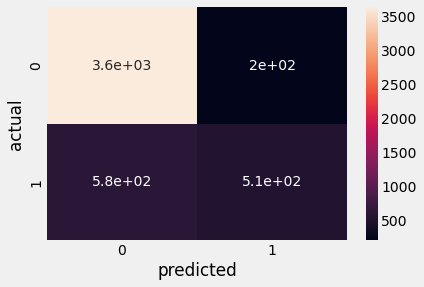

In [13]:
# using deep neural network
from sklearn.metrics import classification_report,confusion_matrix
ann = tf.keras.Sequential([
    tf.keras.Input(shape=[16]),
    tf.keras.layers.Dense(units=5,activation='relu'),
    tf.keras.layers.Dense(units=5,activation='relu'),
    tf.keras.layers.Dense(units=2,activation='softmax')
])


opt = tf.keras.optimizers.Adam()
met = tf.keras.metrics.SparseCategoricalAccuracy()
los = tf.keras.losses.SparseCategoricalCrossentropy()
ann.compile(optimizer = opt,metrics = met,loss = los)

history = ann.fit(xtrain,ytrain,epochs=5,validation_split=1/19)

yhat = ann.predict(xtest)
yhat = yhat.argmax(axis=1)
yhat = yhat.reshape(yhat.shape[0])

print('Error metrics on test set \n',classification_report(ytest,yhat))
sns.heatmap(pd.DataFrame(confusion_matrix(ytest,yhat),columns=[0,1],index=[0,1]),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual') 

<a id = 'conclusion'></a>
### Comparing the performance of all the models

   |Model Name             | TestAccuracy | Precision | Recall | F1 |
   |  :                    |  :           |  :        |   :    | :  |
   |Log Regression         |84|83|84|83|
   |Knn Classifier         |84|83|84|83|
   |Rforest Classifier     |85|84|85|84|
   |Ann Classifier         |84|83|84|83|

- all the models exhibited more or less the same accuracy around 85 % , 
- the performance of all the models is poor
- this may a direct result in sufficient or in accurate data 
  as nearly half of the fields in ( evaporation,sunshine,cloud9am,cloud3am are nulls)

### Report
- The fields Humidity,Pressure,RainToday,Cloud at 9am and 3pm ,sunshine  has the most effect on our
prediction
- although every model is achieving an accuracy close to 85 % ,
- all model's are suffering from the high false negatives ie every model is predicting that tomorrow does not receive any rain even though it rained

------------------------------------------------------------------------------------[BACK TO TOP](#top)